# EEG `.fif` Quick Viewer — MNE-Python

Ein kompaktes, robustes Notebook zum **Lesen, Inspizieren und Visualisieren** von `.fif`-Dateien mit **MNE-Python**.

**Features**
- Laden einer `.fif`
- Übersichtliche Metadaten (Kanäle, Samplingrate, Dauer, Bad Channels)
- Zeitreihen-Vorschau (z-standardisiert)
- Frequenzanalyse (PSD) + Bandpower (Delta/Theta/Alpha/Beta/Gamma)
- Annotations & Events (tabellarisch)
- Optionaler CSV-Export eines Ausschnitts

> Hinweis: `.fif` ist **binär** – „lesbar“ bedeutet hier **Interpretation** (Tabellen/Plots), nicht rohes Öffnen als Text.



In [ ]:
from pathlib import Path

# >>> HIER DEN PFAD ANPASSEN <<<
FIF_PATH = Path("C:\GitHub Repositorys\eeg-brain-interface\results\processed\Aliaa\indoor_processed_raw.fif")  # z.B.: Path("./data/subject01_raw.fif")

# Anzeige-/Analyse-Optionen
PRELOAD = True             # Daten in RAM laden
PREVIEW_SECONDS = 10.0     # Länge des Zeitfensters für Vorschauplots
MAX_CHANNELS_PREVIEW = 8   # max. Kanäle im Zeitreihenplot (Übersicht)
LOW_FREQ, HIGH_FREQ = 1.0, 45.0  # Anzeige-Bandpass (verändert Original nicht)


<>:4: SyntaxWarning: invalid escape sequence '\G'
<>:4: SyntaxWarning: invalid escape sequence '\G'
C:\Users\juliu\AppData\Local\Temp\ipykernel_31896\2935808626.py:4: SyntaxWarning: invalid escape sequence '\G'
  FIF_PATH = Path("C:\GitHub Repositorys\eeg-brain-interface\preprocessed_results\sub-P001_ses-S001_task-Default_run-001_eeg_raw_clean.fif")  # z.B.: Path("./data/subject01_raw.fif")


Zelle 4 — Code (Imports & Laden)

In [2]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Datei laden
if not FIF_PATH.exists():
    raise FileNotFoundError(f"Datei nicht gefunden: {FIF_PATH.resolve()}")

raw = mne.io.read_raw_fif(str(FIF_PATH), preload=PRELOAD, verbose=False)

# Basisinfos
sfreq = raw.info.get("sfreq", None)
n_channels = len(raw.ch_names)
duration_sec = (raw.n_times / sfreq) if sfreq else None
bad_channels = raw.info.get("bads", [])

print(raw)
print("\n--- Überblick ---")
print(f"Datei: {FIF_PATH.name}")
print(f"Samplingrate: {sfreq} Hz")
print(f"Kanäle: {n_channels}")
print(f"Dauer: {duration_sec:.2f} s" if duration_sec is not None else "Dauer: unbekannt")
print(f"Bad Channels: {bad_channels if bad_channels else 'keine'}")


<Raw | sub-P001_ses-S001_task-Default_run-001_eeg_raw_clean.fif, 17 x 397344 (1589.4 s), ~51.6 MiB, data loaded>

--- Überblick ---
Datei: sub-P001_ses-S001_task-Default_run-001_eeg_raw_clean.fif
Samplingrate: 250.0 Hz
Kanäle: 17
Dauer: 1589.38 s
Bad Channels: keine


Zelle 5 — Code (Kanal-Tabelle „menschenlesbar“)

In [4]:
# Tabelle mit Kanal-Metadaten
rows = []
# robust channel type retrieval across MNE versions
for ch_name in raw.ch_names:
    ch_type = raw.get_channel_types(picks=[ch_name])[0]
    rows.append({
        "channel": ch_name,
        "type": ch_type,
        "is_bad": ch_name in raw.info.get("bads", []),
    })

channels_df = pd.DataFrame(rows)
display(channels_df)


,channel,type,is_bad
0,EEG01,eeg,False
1,EEG02,eeg,False
2,EEG03,eeg,False
3,EEG04,eeg,False
4,EEG05,eeg,False
5,EEG06,eeg,False
6,EEG07,eeg,False
7,EEG08,eeg,False
8,EEG09,eeg,False
9,EEG10,eeg,False


Zelle 6 — Code (Anzeige-Filter: Kopie mit Bandpass)

In [5]:
raw_viz = raw.copy().filter(l_freq=LOW_FREQ, h_freq=HIGH_FREQ, picks="data", verbose=False)
print(f"Anzeige-Filter angewandt: {LOW_FREQ}-{HIGH_FREQ} Hz (nur für Visualisierung)")


Anzeige-Filter angewandt: 1.0-45.0 Hz (nur für Visualisierung)


Zelle 7 — Code (Zeitreihen-Vorschau, z-standardisiert)

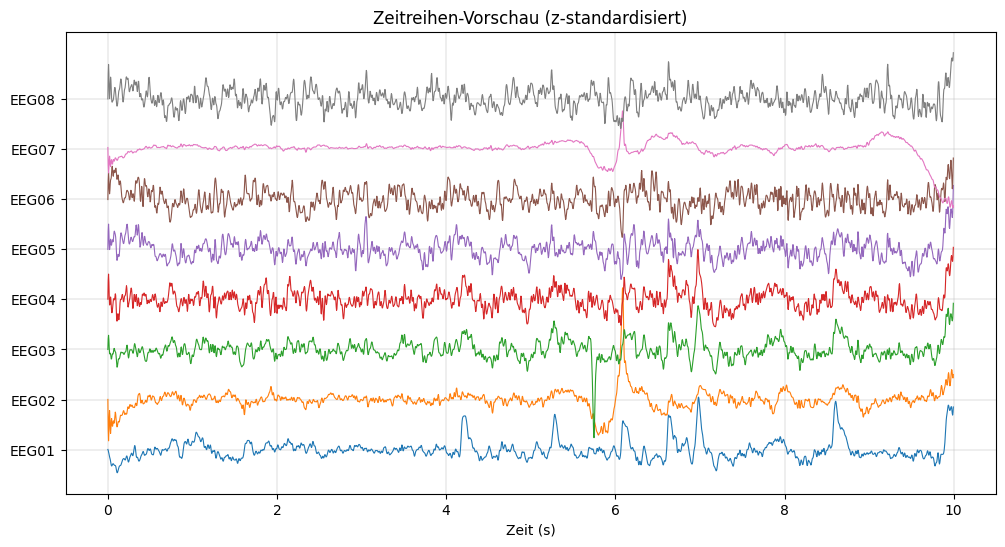

In [6]:
# Picks: bevorzugt EEG, sonst EOG/ECG/MISC
picks = mne.pick_types(raw_viz.info, eeg=True, eog=True, ecg=True, misc=True, meg=False, stim=False, exclude=[])
if len(picks) == 0:
    picks = np.arange(min(len(raw_viz.ch_names), MAX_CHANNELS_PREVIEW))
else:
    picks = picks[:MAX_CHANNELS_PREVIEW]

sf = raw_viz.info["sfreq"]
n_samples = int(PREVIEW_SECONDS * sf)
start = 0
stop = min(raw_viz.n_times, start + n_samples)

data = raw_viz.get_data(picks=picks, start=start, stop=stop)
times = np.arange(stop - start) / sf

# z-Standardisierung pro Kanal
data_z = (data - data.mean(axis=1, keepdims=True)) / (data.std(axis=1, keepdims=True) + 1e-10)

plt.figure(figsize=(12, 6))
offset = 0.0
offsets = []
for i in range(data_z.shape[0]):
    plt.plot(times, data_z[i] + offset, linewidth=0.8)
    offsets.append(offset)
    offset += 5.0  # vertikaler Abstand

plt.yticks(offsets, [raw_viz.ch_names[p] for p in picks])
plt.xlabel("Zeit (s)")
plt.title("Zeitreihen-Vorschau (z-standardisiert)")
plt.grid(True, linewidth=0.3)
plt.show()


Zelle 8 — Code (PSD + Bandpower)

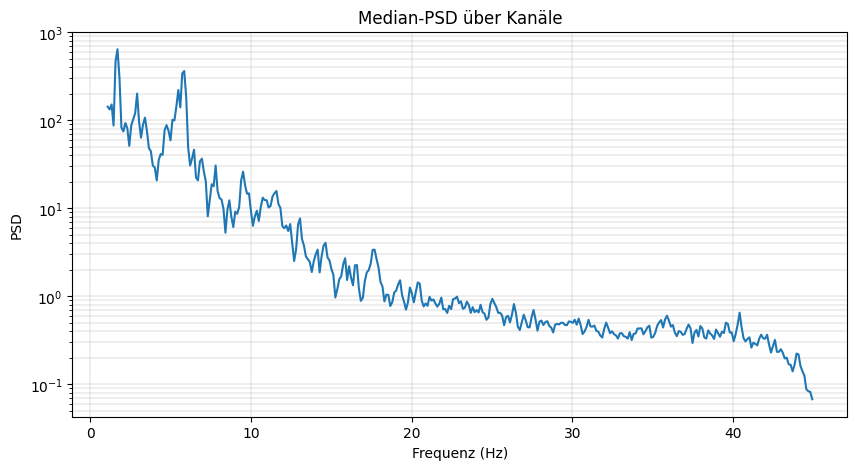

C:\Users\juliu\AppData\Local\Temp\ipykernel_31896\774673737.py:20: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[..., idx], freqs[idx], axis=-1)


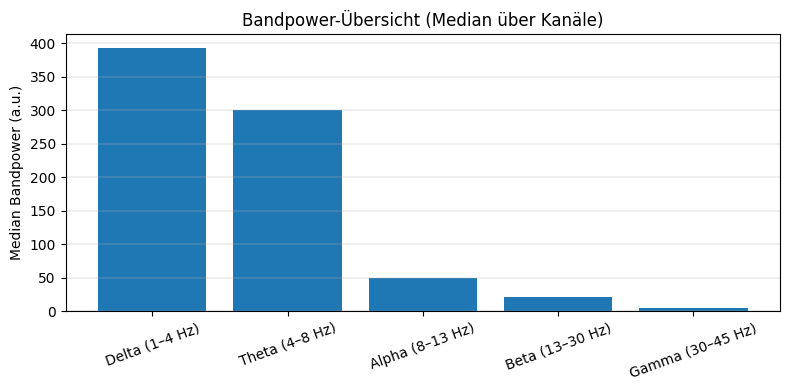

In [7]:
# PSD auf Anzeige-Kopie
spectrum = raw_viz.compute_psd(picks=picks, fmin=1.0, fmax=HIGH_FREQ, n_fft=None, verbose=False)
freqs = spectrum.freqs
psds = spectrum.get_data()  # shape: (n_channels, n_freqs)

# Median-PSD über Kanäle
median_psd = np.median(psds, axis=0)

plt.figure(figsize=(10, 5))
plt.semilogy(freqs, median_psd)
plt.xlabel("Frequenz (Hz)")
plt.ylabel("PSD")
plt.title("Median-PSD über Kanäle")
plt.grid(True, which="both", linewidth=0.3)
plt.show()

# Bandpower-Funktion
def bandpower(psd, freqs, fmin, fmax):
    idx = (freqs >= fmin) & (freqs < fmax)
    return np.trapz(psd[..., idx], freqs[idx], axis=-1)

bands = {
    "Delta (1–4 Hz)": (1.0, 4.0),
    "Theta (4–8 Hz)": (4.0, 8.0),
    "Alpha (8–13 Hz)": (8.0, 13.0),
    "Beta (13–30 Hz)": (13.0, 30.0),
    "Gamma (30–45 Hz)": (30.0, 45.0),
}

bp_values = {}
for name, (fmin, fmax) in bands.items():
    bp_values[name] = np.median(bandpower(psds, freqs, fmin, fmax))

band_names = list(bp_values.keys())
band_vals = [bp_values[k] for k in band_names]

plt.figure(figsize=(8, 4))
plt.bar(band_names, band_vals)
plt.ylabel("Median Bandpower (a.u.)")
plt.title("Bandpower-Übersicht (Median über Kanäle)")
plt.xticks(rotation=20)
plt.grid(True, axis="y", linewidth=0.3)
plt.tight_layout()
plt.show()


Zelle 9 — Code (Annotations & Events)

In [8]:
# Annotations
ann = raw.annotations if hasattr(raw, "annotations") else None
if ann is None or len(ann) == 0:
    print("Keine Annotations vorhanden.")
else:
    ann_df = pd.DataFrame({
        "onset_sec": ann.onset,
        "duration_sec": ann.duration,
        "description": ann.description
    })
    display(ann_df.head(20))

# Events aus Annotations extrahieren
try:
    events, event_id = mne.events_from_annotations(raw, verbose=False)
    if events is not None and len(events) > 0:
        events_df = pd.DataFrame(events, columns=["sample", "prev", "event"])
        inv_map = {v: k for k, v in event_id.items()}
        events_df["label"] = events_df["event"].map(inv_map)
        display(events_df.head(20))
        counts = events_df["label"].value_counts()
        display(pd.DataFrame({"count": counts}))
    else:
        print("Keine Events gefunden.")
except Exception as e:
    print(f"Events konnten nicht extrahiert werden: {e}")


Keine Annotations vorhanden.
Keine Events gefunden.


Zelle 10 — Code (Optional: CSV-Export eines Ausschnitts)

In [9]:
export_seconds = PREVIEW_SECONDS
samples = int(export_seconds * raw_viz.info["sfreq"])
data_export = raw_viz.get_data(picks=picks, start=0, stop=min(samples, raw_viz.n_times))
times_export = np.arange(data_export.shape[1]) / raw_viz.info["sfreq"]

export_df = pd.DataFrame(data_export.T, columns=[raw_viz.ch_names[p] for p in picks])
export_df.insert(0, "time_s", times_export)

out_csv = FIF_PATH.with_suffix("").name + "_preview.csv"
export_df.to_csv(out_csv, index=False)
print(f"Exportiert: {out_csv}")


Exportiert: sub-P001_ses-S001_task-Default_run-001_eeg_raw_clean_preview.csv
